In [22]:
from math import *
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

In [23]:
R1 = R2 = 0.5
Rdc = 0.5
L1 = L2 = 300e-6
C1 = C2 = 0.1e-6
Rc = 10
f = 60
k = 0.1

In [24]:
def CalcularTransformador(v1, Rc, f) -> tuple[complex, complex]:
    w = 2*pi*f
    M = sqrt(L1*L2)*k
    XL1 = L1*w*1j
    XL2 = L2*w*1j
    XM = M*w*1j

    XC1 = 1/(C1*w*1j)
    XC2 = 1/(C2*w*1j)

    Z=np.array([[(R1+XL1+XC1), -XM],[-XM, XL2+R2+((Rc * XC2)/(XC2 + Rc))]])
    V=np.array([v1,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]

i1, i2 = CalcularTransformador(50, Rc, f)
print(f"i1 transformador: {abs(i1)}, {phase(i1)}")
print(f"i2 transformador: {abs(i2)}, {phase(i2)}")


i1 transformador: 0.001884963628671156, 1.5707774766994094
i2 transformador: 2.0302175031442833e-06, 3.1311620426265265


c:\Users\verib\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\verib\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


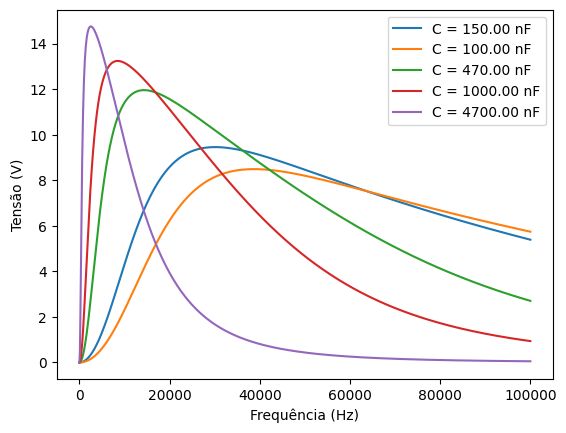

In [25]:
ListaC = [150*1e-9, 0.1*1e-6, 0.47*1e-6, 1e-6, 4.7*1e-6]
lista_fr = np.linspace(1, 100e3, 1000)
for cap in ListaC:
    C1 = C2 = cap
    lista_V2 = []
    for freq in lista_fr:
        w=2*pi*freq
        L1 = L2 =1/(w*w*cap)
        XC1 = XC2 = 1/(cap*1j*w)
        R1 = Rdc + (2*Rdc/100e3) *freq
        R2 = R1
        i1, i2 = CalcularTransformador(10, Rc, freq)
        i4 = ((XC2*i2)/(XC2+Rc))
        lista_V2.append(Rc*i4)

    plt.plot(lista_fr, lista_V2, label=f"C = {cap * 1e9:.2f} nF")

plt.xlabel('Frequência (Hz)')
plt.ylabel('Tensão (V)')
plt.legend()
plt.show()


c:\Users\verib\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\verib\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\verib\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


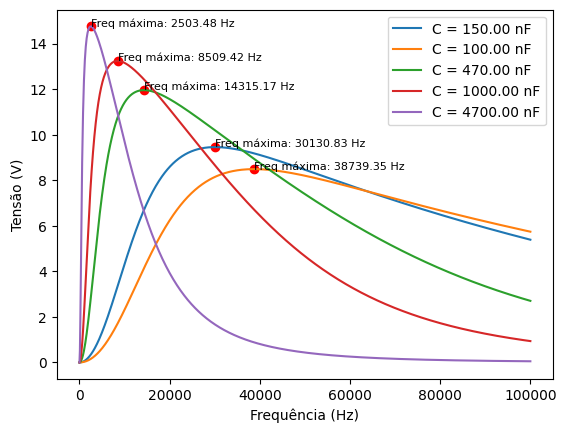

In [26]:
for cap in ListaC:
    C1 = C2 = cap
    lista_V2 = []
    for freq in lista_fr:
        w = 2 * pi * freq
        L1 = L2 = 1 / (w * w * cap)
        XC1 = XC2 = 1 / (cap * 1j * w)
        R1 = Rdc + (2 * Rdc / 100e3) * freq
        R2 = R1
        i1, i2 = CalcularTransformador(10, Rc, freq)
        i4 = ((XC2 * i2) / (XC2 + Rc))
        lista_V2.append(Rc * i4)

    # Encontrar o índice do valor máximo de lista_V2
    indice_maximo = np.argmax(lista_V2)
    # Obter a frequência correspondente ao valor máximo
    freq_maxima = lista_fr[indice_maximo]

    plt.plot(lista_fr, lista_V2, label=f"C = {cap * 1e9:.2f} nF")
    plt.scatter(freq_maxima, lista_V2[indice_maximo], color='red')  # Marcando o ponto máximo

    # Adicionando texto com o valor máximo
    plt.text(freq_maxima, lista_V2[indice_maximo], f"Freq máxima: {freq_maxima:.2f} Hz", fontsize=8)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Tensão (V)')
plt.legend()
plt.show()

In [27]:
f = 8500
w = 2*pi*f
c  = 1e-6
l = 1/(w*w*c)

print(l)

0.0003505923309423453


In [28]:
R1 = 677.3e-3
R2 = 696.6e-3
Rdc = 0.5
L1 = 361.6e-6
L2 = 367.6e-6
C1 = C2 = 1e-6
Rc = 10
f = 8500
k = 0.1

In [29]:
def CalcularTransformador(vp, Rc, f, k) -> tuple[complex, complex]:
    w = 2*pi*f
    M = sqrt(L1*L2)*k
    XL1 = L1*w*1j
    XL2 = L2*w*1j
    XM = M*w*1j
    vi = (2/pi)*vp

    XC1 = 1/(C1*w*1j)
    XC2 = 1/(C2*w*1j)

    Z=np.array([[(R1+XL1+XC1), -XM],[-XM, XL2+R2+((Rc * XC2)/(XC2 + Rc))]])
    V=np.array([v1,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]


In [ ]:

lista_fr = np.linspace(1, 100e3, 1000)

for freq in lista_fr:
    w=2*pi*freq
    L1 = L2 =1/(w*w*cap)
    XC1 = XC2 = 1/(cap*1j*w)
    R1 = Rdc + (2*Rdc/100e3) *freq
    R2 = R1
    i1, i2 = CalcularTransformador(10, Rc, freq)
    i4 = ((XC2*i2)/(XC2+Rc))
    lista_V2.append(Rc*i4)

plt.plot(lista_fr, lista_V2, label=f"C = {cap * 1e9:.2f} nF")